## 사용할 패키지

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMClassifier

import datetime

In [2]:
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

## 데이터 불러오기

In [3]:
site = pd.read_csv('site_info.csv')
energy = pd.read_csv('energy.csv')
dangjin_fcst = pd.read_csv('dangjin_fcst_wind_time.csv')
ulsan_fcst = pd.read_csv('ulsan_fcst_wind_time.csv')

In [4]:
energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0,0
25628,2021-01-31 21:00:00,0.0,0.0,0,0
25629,2021-01-31 22:00:00,0.0,0.0,0,0
25630,2021-01-31 23:00:00,0.0,0.0,0,0


In [5]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,-2.000000,55.000000,6.700000,336.000000,1.0,6.120755,-2.725136,-7.071068e-01,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,-2.333333,55.000000,6.133333,337.000000,1.0,5.645763,-2.396484,-8.660254e-01,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,-2.666667,55.000000,5.566667,338.000000,1.0,5.161323,-2.085310,-9.659258e-01,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,-3.000000,55.000000,5.000000,339.000000,1.0,4.667902,-1.791840,-1.000000e+00,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,-3.333333,56.666667,4.700000,343.666667,1.0,4.510317,-1.321758,-9.659258e-01,2.588190e-01,0.859748,0.510719
...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,5.333333,83.333333,7.466667,20.333333,4.0,7.001396,2.594527,5.000000e-01,-8.660254e-01,0.858846,0.512234
26300,2021-03-01 20:00:00,4.666667,81.666667,7.333333,23.666667,4.0,6.716573,2.943710,2.588190e-01,-9.659258e-01,0.859213,0.511618
26301,2021-03-01 21:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,4.907520e-12,-1.000000e+00,0.859579,0.511002
26302,2021-03-01 22:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,-2.588190e-01,-9.659258e-01,0.859945,0.510386


In [6]:
ulsan_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,0.0,40.000000,1.500000,318.000000,2.000000,1.114717,-1.003696,-0.707107,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,0.0,39.444444,1.511111,318.222222,1.888889,1.126888,-1.006768,-0.866025,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,0.0,38.888889,1.522222,318.444444,1.777778,1.139098,-1.009760,-0.965926,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,0.0,38.333333,1.533333,318.666667,1.666667,1.151349,-1.012673,-1.000000,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,0.0,37.777778,1.544444,318.888889,1.555556,1.163640,-1.015505,-0.965926,2.588190e-01,0.859748,0.510719


기상 예보는 전날 14시(오후 2시) 예보를 선형보간하여 사용하였습니다.

※ 기상 예보 전치리 과정 : https://dacon.io/competitions/official/235720/codeshare/2499?page=1&dtype=recent

In [7]:
def transform_wind_to_vector(df_):
    df = df_.copy()

    wv = df['WindSpeed']

    # Convert to radians.
    wd_rad = df['WindDirection']*np.pi / 180

    # Calculate the wind x and y components.
    df['Wind_X'] = wv*np.cos(wd_rad)
    df['Wind_Y'] = wv*np.sin(wd_rad)
    
    return df

In [8]:
def transform_datetime_to_signal(df_):
    df = df_.copy()
    date_time = pd.to_datetime(df['Forecast_time'], format='%Y.%m.%d %H:%M')
    timestamp_s = date_time.map(datetime.datetime.timestamp)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return df

In [9]:
dangjin_fcst = transform_wind_to_vector(dangjin_fcst)
dangjin_fcst = transform_datetime_to_signal(dangjin_fcst)

In [10]:
dangjin_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,-2.000000,55.000000,6.700000,336.000000,1.0,6.120755,-2.725136,-0.707107,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,-2.333333,55.000000,6.133333,337.000000,1.0,5.645763,-2.396484,-0.866025,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,-2.666667,55.000000,5.566667,338.000000,1.0,5.161323,-2.085310,-0.965926,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,-3.000000,55.000000,5.000000,339.000000,1.0,4.667902,-1.791840,-1.000000,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,-3.333333,56.666667,4.700000,343.666667,1.0,4.510317,-1.321758,-0.965926,2.588190e-01,0.859748,0.510719


In [11]:
ulsan_fcst = transform_wind_to_vector(ulsan_fcst)
ulsan_fcst = transform_datetime_to_signal(ulsan_fcst)

In [12]:
ulsan_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,0.0,40.000000,1.500000,318.000000,2.000000,1.114717,-1.003696,-0.707107,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,0.0,39.444444,1.511111,318.222222,1.888889,1.126888,-1.006768,-0.866025,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,0.0,38.888889,1.522222,318.444444,1.777778,1.139098,-1.009760,-0.965926,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,0.0,38.333333,1.533333,318.666667,1.666667,1.151349,-1.012673,-1.000000,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,0.0,37.777778,1.544444,318.888889,1.555556,1.163640,-1.015505,-0.965926,2.588190e-01,0.859748,0.510719


In [13]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,-2.000000,55.000000,6.700000,336.000000,1.0,6.120755,-2.725136,-7.071068e-01,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,-2.333333,55.000000,6.133333,337.000000,1.0,5.645763,-2.396484,-8.660254e-01,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,-2.666667,55.000000,5.566667,338.000000,1.0,5.161323,-2.085310,-9.659258e-01,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,-3.000000,55.000000,5.000000,339.000000,1.0,4.667902,-1.791840,-1.000000e+00,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,-3.333333,56.666667,4.700000,343.666667,1.0,4.510317,-1.321758,-9.659258e-01,2.588190e-01,0.859748,0.510719
...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,5.333333,83.333333,7.466667,20.333333,4.0,7.001396,2.594527,5.000000e-01,-8.660254e-01,0.858846,0.512234
26300,2021-03-01 20:00:00,4.666667,81.666667,7.333333,23.666667,4.0,6.716573,2.943710,2.588190e-01,-9.659258e-01,0.859213,0.511618
26301,2021-03-01 21:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,4.907520e-12,-1.000000e+00,0.859579,0.511002
26302,2021-03-01 22:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,-2.588190e-01,-9.659258e-01,0.859945,0.510386


## 일사량 추가하기

In [14]:
def sind(degree):
    return np.sin(np.radians(degree))
def cosd(degree):
    return np.cos(np.radians(degree))
def arcsind(degree):
    return np.arcsin(np.radians(degree))
def arccosd(degree):
    return np.arccos(np.radians(degree))

In [15]:
def sunDeclination(day):                                    # 태양 적위
    return 23.45 * sind((360 / 365) * (day - 81))

In [16]:
def sunAltitude(latitude, declination, hour):               # 태양 고도
    l, d, H = latitude, declination, hour
    h = (sind(l) * sind(d)) + (cosd(l) * cosd(d) * cosd(H))
    h = np.degrees(np.arcsin(h))
    return h

In [17]:
def sunRiseSet(latitude, declination, longitude):           # 일출 일몰 시간
    lat, d, long = latitude, declination, longitude
    b = (-1 * sind(lat) * sind(d)) / (cosd(lat) * cosd(d))
    b = np.degrees(np.arccos(b)) / 15
    d = longitude / 15                                      # 경도에 따른 시간 보정 (GMT +9:00는 경도 135도) 
    r = 0.00625                                             # refraction_rate, 굴절에 따른 시간 보정 (약 9분)
    sunrise = 12 - b - d + r
    sunset = 12 + b - d - r
    return sunrise, sunset

In [18]:
def directInsolation(altitude):                             # 직사 일사량
    am = 1/cosd(90 - altitude)                              # airmass
    I = 1.353 * 0.7 ** (am ** 0.678)                        # direct insolation
    return I

In [19]:
tokyo_longitude = 135.0

dangjin_latitude = float(site.loc[site['Id'] == '당진태양광', 'Latitude'])
dangjin_longitude = float(site.loc[site['Id'] == '당진태양광', 'Longitude'])

ulsan_latitude = float(site.loc[site['Id'] == '울산태양광', 'Latitude'])
ulsan_longitude = float(site.loc[site['Id'] == '울산태양광', 'Longitude'])

dangjin_latitude, dangjin_longitude, ulsan_latitude, ulsan_longitude

(37.0507527, 126.5102993, 35.47765089999999, 129.380778)

In [20]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,-2.000000,55.000000,6.700000,336.000000,1.0,6.120755,-2.725136,-7.071068e-01,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,-2.333333,55.000000,6.133333,337.000000,1.0,5.645763,-2.396484,-8.660254e-01,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,-2.666667,55.000000,5.566667,338.000000,1.0,5.161323,-2.085310,-9.659258e-01,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,-3.000000,55.000000,5.000000,339.000000,1.0,4.667902,-1.791840,-1.000000e+00,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,-3.333333,56.666667,4.700000,343.666667,1.0,4.510317,-1.321758,-9.659258e-01,2.588190e-01,0.859748,0.510719
...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,5.333333,83.333333,7.466667,20.333333,4.0,7.001396,2.594527,5.000000e-01,-8.660254e-01,0.858846,0.512234
26300,2021-03-01 20:00:00,4.666667,81.666667,7.333333,23.666667,4.0,6.716573,2.943710,2.588190e-01,-9.659258e-01,0.859213,0.511618
26301,2021-03-01 21:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,4.907520e-12,-1.000000e+00,0.859579,0.511002
26302,2021-03-01 22:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,-2.588190e-01,-9.659258e-01,0.859945,0.510386


In [21]:
dangjin_insola = pd.DataFrame(data=[sunDeclination(i//24) for i in range(365 * 24 * 4 + 24)], columns=['declination'])

dangjin_insola['sunrise'], dangjin_insola['sunset'] = sunRiseSet(dangjin_latitude, dangjin_insola['declination'], dangjin_longitude - tokyo_longitude)

# (00시는 -180°, 06시는 -90°, 12시는 0°, 18시는 +90°, 24시는 +180°)
dangjin_insola['altitude'] = sunAltitude(dangjin_latitude, dangjin_insola['declination'], [(i % 24) * 15 - 180 for i in range(365 * 24 * 4 + 24)]) 
dangjin_insola.loc[dangjin_insola['altitude'] < 0, 'altitude'] = 0

dangjin_insola['Insolation'] = directInsolation(dangjin_insola['altitude'])

dangjin_insola['Forecast_time'] = pd.date_range('2018-01-01 00:00:00', '2021-12-31 23:00:00', freq='H')

start = '2018-03-02 00:00:00'
end = '2021-03-01 23:00:00'

start_idx = dangjin_insola[dangjin_insola['Forecast_time']==start].index[0]
end_idx = dangjin_insola[dangjin_insola['Forecast_time']==end].index[0]

dangjin_insola = dangjin_insola.loc[start_idx:end_idx, :].copy()
dangjin_insola.index = range(dangjin_insola.shape[0])

dangjin_insola['Forecast_time'] = dangjin_insola['Forecast_time'].astype(str)

dangjin_insola

,declination,sunrise,sunset,altitude,Insolation,Forecast_time
0,-8.293705,6.993442,18.138518,0.0,0.0,2018-03-02 00:00:00
1,-8.293705,6.993442,18.138518,0.0,0.0,2018-03-02 01:00:00
2,-8.293705,6.993442,18.138518,0.0,0.0,2018-03-02 02:00:00
3,-8.293705,6.993442,18.138518,0.0,0.0,2018-03-02 03:00:00
4,-8.293705,6.993442,18.138518,0.0,0.0,2018-03-02 04:00:00
...,...,...,...,...,...,...
26299,-8.293705,6.993442,18.138518,0.0,0.0,2021-03-01 19:00:00
26300,-8.293705,6.993442,18.138518,0.0,0.0,2021-03-01 20:00:00
26301,-8.293705,6.993442,18.138518,0.0,0.0,2021-03-01 21:00:00
26302,-8.293705,6.993442,18.138518,0.0,0.0,2021-03-01 22:00:00


In [22]:
ulsan_insola = pd.DataFrame(data=[sunDeclination(i//24) for i in range(365 * 24 * 4 + 24)], columns=['declination'])

ulsan_insola['sunrise'], dangjin_insola['sunset'] = sunRiseSet(ulsan_latitude, ulsan_insola['declination'], ulsan_longitude - tokyo_longitude)

# (00시는 -180°, 06시는 -90°, 12시는 0°, 18시는 +90°, 24시는 +180°)
ulsan_insola['altitude'] = sunAltitude(ulsan_latitude, ulsan_insola['declination'], [(i % 24) * 15 - 180 for i in range(365 * 24 * 4 + 24)]) 
ulsan_insola.loc[ulsan_insola['altitude'] < 0, 'altitude'] = 0

ulsan_insola['Insolation'] = directInsolation(ulsan_insola['altitude'])

ulsan_insola['Forecast_time'] = pd.date_range('2018-01-01 00:00:00', '2021-12-31 23:00:00', freq='H')

start = '2018-03-02 00:00:00'
end = '2021-03-01 23:00:00'

start_idx = ulsan_insola[ulsan_insola['Forecast_time']==start].index[0]
end_idx = ulsan_insola[ulsan_insola['Forecast_time']==end].index[0]

ulsan_insola = ulsan_insola.loc[start_idx:end_idx, :].copy()
ulsan_insola.index = range(ulsan_insola.shape[0])

ulsan_insola['Forecast_time'] = ulsan_insola['Forecast_time'].astype(str)

ulsan_insola

,declination,sunrise,altitude,Insolation,Forecast_time
0,-8.293705,6.778422,0.0,0.0,2018-03-02 00:00:00
1,-8.293705,6.778422,0.0,0.0,2018-03-02 01:00:00
2,-8.293705,6.778422,0.0,0.0,2018-03-02 02:00:00
3,-8.293705,6.778422,0.0,0.0,2018-03-02 03:00:00
4,-8.293705,6.778422,0.0,0.0,2018-03-02 04:00:00
...,...,...,...,...,...
26299,-8.293705,6.778422,0.0,0.0,2021-03-01 19:00:00
26300,-8.293705,6.778422,0.0,0.0,2021-03-01 20:00:00
26301,-8.293705,6.778422,0.0,0.0,2021-03-01 21:00:00
26302,-8.293705,6.778422,0.0,0.0,2021-03-01 22:00:00


In [23]:
dangjin_fcst = pd.merge(dangjin_fcst, dangjin_insola, on='Forecast_time', how='outer')
ulsan_fcst = pd.merge(ulsan_fcst, ulsan_insola, on='Forecast_time', how='outer')
# dangjin_fcst
# ulsan_fcst

In [24]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos,declination,sunrise,sunset,altitude,Insolation
0,2018-03-02 00:00:00,-2.000000,55.000000,6.700000,336.000000,1.0,6.120755,-2.725136,-7.071068e-01,-7.071068e-01,0.858280,0.513182,-8.293705,6.993442,17.189351,0.0,0.0
1,2018-03-02 01:00:00,-2.333333,55.000000,6.133333,337.000000,1.0,5.645763,-2.396484,-8.660254e-01,-5.000000e-01,0.858648,0.512566,-8.293705,6.993442,17.189351,0.0,0.0
2,2018-03-02 02:00:00,-2.666667,55.000000,5.566667,338.000000,1.0,5.161323,-2.085310,-9.659258e-01,-2.588190e-01,0.859015,0.511951,-8.293705,6.993442,17.189351,0.0,0.0
3,2018-03-02 03:00:00,-3.000000,55.000000,5.000000,339.000000,1.0,4.667902,-1.791840,-1.000000e+00,-3.848660e-12,0.859382,0.511335,-8.293705,6.993442,17.189351,0.0,0.0
4,2018-03-02 04:00:00,-3.333333,56.666667,4.700000,343.666667,1.0,4.510317,-1.321758,-9.659258e-01,2.588190e-01,0.859748,0.510719,-8.293705,6.993442,17.189351,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,5.333333,83.333333,7.466667,20.333333,4.0,7.001396,2.594527,5.000000e-01,-8.660254e-01,0.858846,0.512234,-8.293705,6.993442,17.189351,0.0,0.0
26300,2021-03-01 20:00:00,4.666667,81.666667,7.333333,23.666667,4.0,6.716573,2.943710,2.588190e-01,-9.659258e-01,0.859213,0.511618,-8.293705,6.993442,17.189351,0.0,0.0
26301,2021-03-01 21:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,4.907520e-12,-1.000000e+00,0.859579,0.511002,-8.293705,6.993442,17.189351,0.0,0.0
26302,2021-03-01 22:00:00,4.000000,80.000000,7.200000,27.000000,4.0,6.415247,3.268732,-2.588190e-01,-9.659258e-01,0.859945,0.510386,-8.293705,6.993442,17.189351,0.0,0.0


In [25]:
ulsan_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos,declination,sunrise,altitude,Insolation
0,2018-03-02 00:00:00,0.0,40.000000,1.500000,318.000000,2.000000,1.114717,-1.003696,-0.707107,-7.071068e-01,0.858280,0.513182,-8.293705,6.778422,0.0,0.0
1,2018-03-02 01:00:00,0.0,39.444444,1.511111,318.222222,1.888889,1.126888,-1.006768,-0.866025,-5.000000e-01,0.858648,0.512566,-8.293705,6.778422,0.0,0.0
2,2018-03-02 02:00:00,0.0,38.888889,1.522222,318.444444,1.777778,1.139098,-1.009760,-0.965926,-2.588190e-01,0.859015,0.511951,-8.293705,6.778422,0.0,0.0
3,2018-03-02 03:00:00,0.0,38.333333,1.533333,318.666667,1.666667,1.151349,-1.012673,-1.000000,-3.848660e-12,0.859382,0.511335,-8.293705,6.778422,0.0,0.0
4,2018-03-02 04:00:00,0.0,37.777778,1.544444,318.888889,1.555556,1.163640,-1.015505,-0.965926,2.588190e-01,0.859748,0.510719,-8.293705,6.778422,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26302,2021-03-01 22:00:00,12.0,80.000000,4.233333,27.000000,4.000000,3.771928,1.921893,-0.258819,-9.659258e-01,0.859945,0.510386,-8.293705,6.778422,0.0,0.0
26303,2021-03-01 23:00:00,10.0,80.000000,4.666667,22.000000,4.000000,4.326858,1.748164,-0.500000,-8.660254e-01,0.860311,0.509769,-8.293705,6.778422,0.0,0.0
26304,2021-03-02 00:00:00,8.0,80.000000,5.100000,17.000000,4.000000,4.877154,1.491096,-0.707107,-7.071068e-01,0.860676,0.509153,NaN,NaN,NaN,NaN
26305,2021-03-02 03:00:00,6.0,80.000000,7.200000,10.000000,4.000000,7.090616,1.250267,-1.000000,-7.470864e-12,0.861769,0.507301,NaN,NaN,NaN,NaN


In [26]:
dangjin_fcst.to_csv("add_dangjin_wind_time_insolation.csv", index=False)
ulsan_fcst.to_csv("add_ulsan_wind_time_insolation.csv", index=False)

## 학습 데이터 전처리

In [27]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    # feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    feature_df = concat_df[[#'year', 'month', 'day', 'hour', 
                            'Year sin', 'Year cos', 'Day sin', 'Day cos',
                            'Temperature', 'Humidity', 
#                             'WindSpeed', 'WindDirection',
                            'Wind_X', 'Wind_Y',
                            'Insolation',
                            'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    #train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_x = train_df.loc[:, :'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    #val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_x = val_df.loc[:, :'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## LightGBM Custom Metric

In [28]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

## Validation Metric

In [29]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

## LightGBM Hyperparameter

In [30]:
# params = {
#     'seed':42,
#     'boosting': 'gbdt',
#     'objective': 'regression',
#     'metric':'mae',
#     'num_iterations': 10000,
#     'learning_rate': 0.01,
# #     'max_depth': -1, # 최대 깊이 트리를 만듬
#     'max_depth': 16,
#     'num_leaves': 39000,
#     'bagging_freq': 2,
#     'bagging_fraction': 0.7,
#     'feature_fraction': 0.8,
# }

In [31]:
# 2021년 1월 데이터를 테스트 데이터로
def preprocess_df(df_, test_length=31*24+23):
    target_columns = []
    df = df_copy()
    n = len(df)
    train_mean = df[0:int(n*0.9)][target_columns].mean()
    train_std = df[0:int(n*0.9)][target_columns].std()
    
    df[target_columns] = (df[target_columns] - train_mean) / train_std
    
    train_df = df[0:n-test_length]
    test_df = df[n-test_length:]
    
    return train_mean, train_std, train_df, test_df

In [32]:
def custom_nmae(answer_energy, submission_energy, site_name, train_mean, train_std):
    # 발전소 발전용량
    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dnagjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }
    
    sum_answer = answer_energy * train_std['energy'] + train_mean['energy']
    sum_submission = submission_energy * train_std['energy'] + train_mean['energy']
    
    # 총 발전용량 절대오차
    absolute_error = abs((sum_answer - sum_submission))
    
    # 발전용량으로 정규화
    total_capacity = capacity[site_name]
    absolute_error /= total_capacity
    
    # 총 발전용량의 10% 이상 발전한 데이터 인덱스 추출
    # NMAE(%)
    nmae = 100 * absolute_error[sum_answer>=total_capacity*0.1].mean()
    
    return nmae

## Optuna Hyperparameter Setting

In [33]:
# # 기본 패러미터
# params_default = {
#         'seed':42,
#         'boosting': 'gbdt',
#         'objective': 'regression',
#         'metric':'mae',
#         'num_iterations': 10000,
#         'learning_rate': 0.01,
# }

In [34]:
# 기본 패러미터
params_default = {
    #'seed':42,
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric':'mae',
    'num_iterations': 10000,
    'learning_rate': 0.01,
    # 'max_depth': 16,
    # 'num_leaves': 39000,
    'bagging_freq': 2,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.8,
}

In [45]:
def objectiveLGBM(trial: Trial, energy, fcst, target):
    params = {
        'seed':42,
        'boosting': 'gbdt',
        # 'boosting': trial.suggest_categorical('boosting', ['gbdt', 'dart']),
        'objective': 'regression',
        'metric':'mae',
        'num_iterations': 10000,
        'learning_rate': 0.01,
        # 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'num_leaves': trial.suggest_int('num_leaves', 2, 65535),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 1000),
        # 'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        # 'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 0, 5),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        # 'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 1.5),
        # 'max_bin': trial.suggest_int('max_bin', 1, 1000),
    }

    train_x, train_y, val_x, val_y = train_datast(energy, fcst, target)
    train_dataset = lgb.Dataset(train_x, train_y)
    val_dataset = lgb.Dataset(val_x, val_y)

    # model = LGBMClassifier(**params)
    # model.fit(train_dataset, val_dataset, verbose=False)

    model = lgb.train(params, train_dataset, valid_sets=val_dataset, early_stopping_rounds=100, feval=nmae_10, verbose_eval=False)
    # model = lgb.train(params, train_dataset, val_dataset, verbose_eval=False)

    pred = model.predict(val_x)
    score = sola_nmae(val_y, pred)

    return score

In [46]:
# 패러미터 그래프가 궁금할때 쓰는 코드들
# # 하이퍼파라미터 최적화 과정을 확인
# optuna.visualization.plot_optimization_history(study)

# # 하이퍼파라미터별 중요도
# optuna.visualization.plot_param_importances(study)

# # 파라미터들관의 관계
# optuna.visualization.plot_parallel_coordinate(study)

### 당진수상태양광 예측 모델 학습

In [47]:
capacity = 1000

sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(lambda trial: objectiveLGBM(trial, energy, dangjin_fcst, target='dangjin_floating'), n_trials=20)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

tive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [48]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)

In [49]:
# 하이퍼파라미터별 중요도
optuna.visualization.plot_param_importances(study)

In [50]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [51]:
params_floating = params_default.copy()
params_floating.update(study.best_trial.params)

In [52]:
params_floating

{'boosting': 'gbdt',
 'objective': 'regression',
 'metric': 'mae',
 'num_iterations': 10000,
 'learning_rate': 0.01,
 'bagging_freq': 2,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.8,
 'max_depth': 34,
 'num_leaves': 27221,
 'min_data_in_leaf': 48}

In [53]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params_floating, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

ing] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

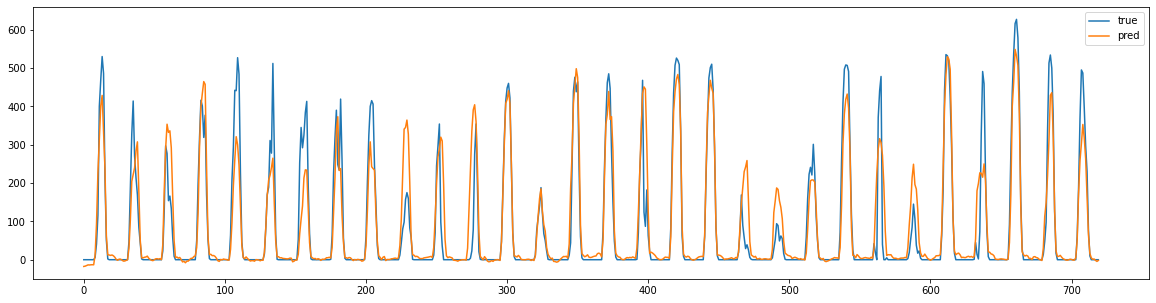

CV Score :  7.974692398241999


In [54]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진자재창고태양광 예측 모델 학습

In [55]:
capacity = 700

sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(lambda trial: objectiveLGBM(trial, energy, dangjin_fcst, target='dangjin_warehouse'), n_trials=20)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

ive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [56]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)

In [57]:
# 하이퍼파라미터별 중요도
optuna.visualization.plot_param_importances(study)

In [58]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [59]:
params_warehouse = params_default.copy()
params_warehouse.update(study.best_trial.params)

In [60]:
params_warehouse

{'boosting': 'gbdt',
 'objective': 'regression',
 'metric': 'mae',
 'num_iterations': 10000,
 'learning_rate': 0.01,
 'bagging_freq': 2,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.8,
 'max_depth': 36,
 'num_leaves': 46222,
 'min_data_in_leaf': 57}

In [61]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params_warehouse, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

rning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

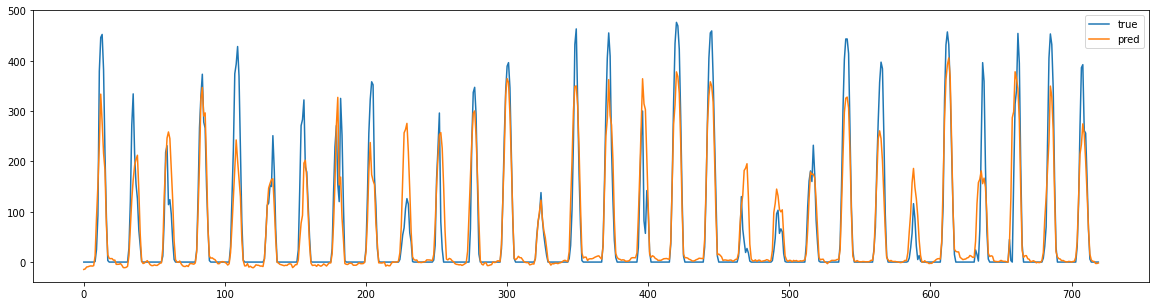

CV Score :  9.947000898062493


In [65]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진태양광 예측 모델 학습

In [66]:
capacity = 1000

sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(lambda trial: objectiveLGBM(trial, energy, dangjin_fcst, target='dangjin'), n_trials=20)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

tive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [67]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)

In [68]:
# 하이퍼파라미터별 중요도
optuna.visualization.plot_param_importances(study)

In [69]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [70]:
params_dangjin = params_default.copy()
params_dangjin.update(study.best_trial.params)

In [71]:
params_dangjin

{'boosting': 'gbdt',
 'objective': 'regression',
 'metric': 'mae',
 'num_iterations': 10000,
 'learning_rate': 0.01,
 'bagging_freq': 2,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.8,
 'max_depth': 24,
 'num_leaves': 63183,
 'min_data_in_leaf': 63}

In [72]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params_dangjin, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

ing] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

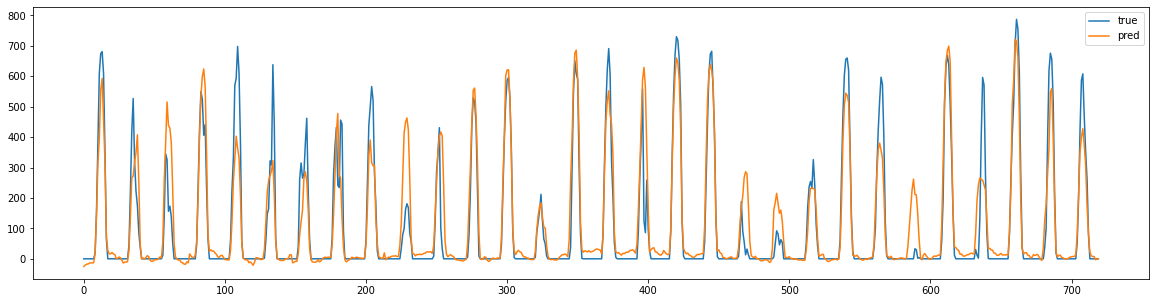

CV Score :  10.0936082707102


In [73]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 울산태양광 예측 모델 학습

In [74]:
capacity = 500

sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(lambda trial: objectiveLGBM(trial, energy, ulsan_fcst, target='ulsan'), n_trials=20)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

tive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [75]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)

In [76]:
# 하이퍼파라미터별 중요도
optuna.visualization.plot_param_importances(study)

In [77]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [78]:
params_ulsan = params_default.copy()
params_ulsan.update(study.best_trial.params)

In [79]:
params_ulsan

{'boosting': 'gbdt',
 'objective': 'regression',
 'metric': 'mae',
 'num_iterations': 10000,
 'learning_rate': 0.01,
 'bagging_freq': 2,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.8,
 'max_depth': 38,
 'num_leaves': 28567,
 'min_data_in_leaf': 21}

In [80]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params_ulsan, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

ning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

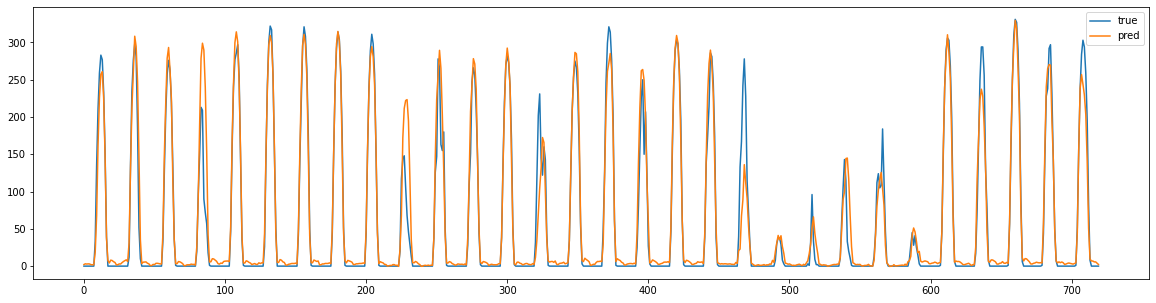

CV Score :  5.687850909113811


In [81]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## 테스트 데이터 전처리

In [82]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    #test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    test_df = test_df[[ #'year', 'month', 'day', 'hour', 
                        'Year sin', 'Year cos', 'Day sin', 'Day cos',
                        'Temperature', 'Humidity', 
#                         'WindSpeed', 'WindDirection',
                        'Wind_X', 'Wind_Y',
                        'Insolation',
                        'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [83]:
dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)

## 각 발전소 발전량 추론

In [84]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

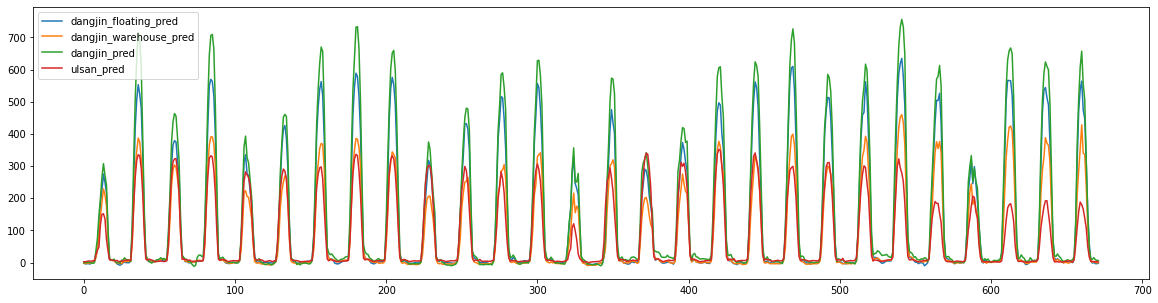

In [85]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

## 제출

In [86]:
submission = pd.read_csv('sample_submission.csv')

In [87]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [88]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,-1.837282,-2.546324,-1.262562,2.246987
1,2021-02-01 02:00:00,-4.150089,-2.955872,-0.063659,2.471116
2,2021-02-01 03:00:00,-3.889122,-2.624184,-0.735994,3.268185
3,2021-02-01 04:00:00,-3.050810,-2.273911,0.673149,4.545284
4,2021-02-01 05:00:00,-4.983073,-2.065009,0.122610,4.320815
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [89]:
submission.to_csv('dacon_baseline_wind_time_insolation_optuna_test2.csv', index=False)
# submission.to_csv('dacon_baseline_time_insolation.csv', index=False)

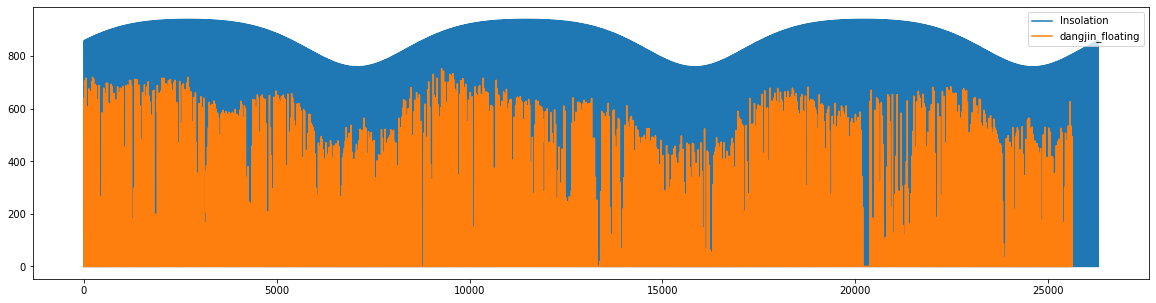

In [90]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_fcst['Insolation'] * 1000, label='Insolation')
plt.plot(energy['dangjin_floating'], label='dangjin_floating')
#plt.plot([declination(i/10) for i in range(3650)], label='true')
plt.legend()
plt.show()

In [91]:
# 일기 예보 있는 날짜만 선택
energy_ = energy.loc[24:]
energy_.index = range(energy_.shape[0])

# 발전량 데이터가 있는 날짜만 선택
dangjin_fcst_ = dangjin_fcst.loc[:25608-1]
dangjin_fcst_.index = range(dangjin_fcst_.shape[0])

# 예보 시간 및 날짜 정보 feature로 추가
dangjin_fcst_['date'] = dangjin_fcst_['Forecast_time'].str.split(' ').str[0]
dangjin_fcst_['hour'] = dangjin_fcst_['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)

dangjin_fcst_['year'] = dangjin_fcst_['date'].str.split('-').str[0].astype(int)
dangjin_fcst_['month'] = dangjin_fcst_['date'].str.split('-').str[1].astype(int)
dangjin_fcst_['day'] = dangjin_fcst_['date'].str.split('-').str[2].astype(int)

# 발전량과 일기예보 연결
heat_df = pd.concat([energy_, dangjin_fcst_], axis=1)
heat_df = heat_df[[ #'month', 'hour', 'day', 'hour',
                    #'Year sin', 'Year cos', 'Day sin', 'Day cos',
                    'Temperature', 'Humidity', 
#                     'WindSpeed', 'WindDirection',
                    'Wind_X', 'Wind_Y',
                    'Insolation',
                    'Cloud',
                    'dangjin']]

ipykernel_launcher:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

ipykernel_launcher:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

ipykernel_launcher:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

ipykernel_launcher:14: SettingWithCopyWarning:


A value is t

In [92]:
heat_corr = heat_df.corr()

<AxesSubplot:>

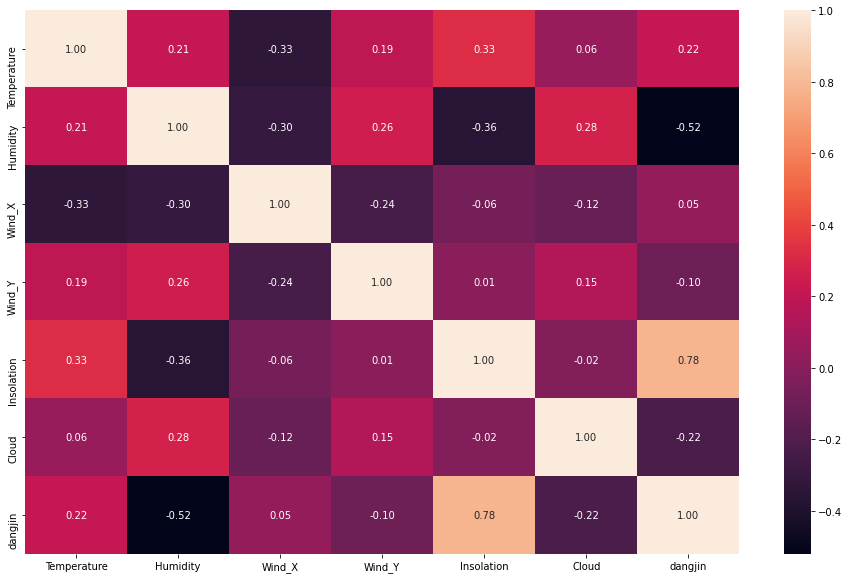

In [93]:
plt.figure(figsize=(16,10))
sns.heatmap(data = heat_corr, annot=True, fmt = '.2f')